In [168]:
import pandas as pd
import tensorflow as tf
import umap
from collections import Counter
%load_ext rpy2.ipython

In [169]:
train_64_aug = pd.read_pickle('train_64_aug.pkl')
test_64_aug = pd.read_pickle('test_64_aug.pkl')

In [170]:
cnn_embedder = tf.keras.models.load_model('cnn_embedder_32')

In [171]:
encoder = tf.keras.layers.TextVectorization(standardize=None)
encoder.adapt(train_64_aug.Chunk)

In [172]:
aug_syls = pd.DataFrame()
# redundant looking string cast from numpy.str_ to python str saves a warning
# later. Skip UNK, '' and EOL
aug_syls['raw'] = [str(x) for x in encoder.get_vocabulary()[3:]]
aug_syls['encoded'] = encoder(aug_syls['raw']) 
aug_syls['embedded'] = [x[0] for x in cnn_embedder.predict(aug_syls.encoded)]
aug_syls

299/299 [==============================] - 0s 972us/step


,raw,encoded,embedded
0,kwe+WC,3,"[0.024325399, -0.010502114, -0.035120953, 0.00..."
1,a+DI,4,"[0.04141243, -0.044041567, -0.049202073, -0.03..."
2,ti,5,"[0.001972507, -0.010903611, -0.006923889, -0.0..."
3,ni,6,"[-0.022802254, -0.04014928, -0.04110156, 0.013..."
4,mi,7,"[0.04421917, -0.04648611, 0.009247382, -0.0386..."
...,...,...,...
9558,dur+L+S,9561,"[0.03267215, 0.00890705, -0.044085357, -0.0277..."
9559,tok+L+S+DI,9562,"[0.059608813, 0.006287487, -0.014405831, -0.04..."
9560,rob+L+S+DI,9563,"[-0.020359207, 0.01862291, -0.02346746, -0.051..."
9561,ret+L+S,9564,"[0.0014085862, -0.042289224, 0.01657051, -0.02..."


In [173]:
umapper = umap.UMAP(
    n_neighbors=50,
    min_dist = 0,
    # project to 2 dimensions
    n_components=2,
    metric='mahalanobis',
    # UMAP figures change with every run if not seeded
    random_state=2022
)

In [174]:
u = umapper.fit_transform(aug_syls.embedded.tolist())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/ben/miniconda3/lib/python3.9/site-packages/pynndescent/pynndescent_.py:906: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(


In [175]:
aug_syls['X'], aug_syls['Y'] = u[:,0], u[:,1]
aug_syls

,raw,encoded,embedded,X,Y
0,kwe+WC,3,"[0.024325399, -0.010502114, -0.035120953, 0.00...",5.135891,5.054886
1,a+DI,4,"[0.04141243, -0.044041567, -0.049202073, -0.03...",5.376359,6.010291
2,ti,5,"[0.001972507, -0.010903611, -0.006923889, -0.0...",6.231085,6.508282
3,ni,6,"[-0.022802254, -0.04014928, -0.04110156, 0.013...",3.648831,5.534250
4,mi,7,"[0.04421917, -0.04648611, 0.009247382, -0.0386...",6.172863,3.736936
...,...,...,...,...,...
9558,dur+L+S,9561,"[0.03267215, 0.00890705, -0.044085357, -0.0277...",5.992835,5.959364
9559,tok+L+S+DI,9562,"[0.059608813, 0.006287487, -0.014405831, -0.04...",5.599508,5.653897
9560,rob+L+S+DI,9563,"[-0.020359207, 0.01862291, -0.02346746, -0.051...",5.667487,6.543437
9561,ret+L+S,9564,"[0.0014085862, -0.042289224, 0.01657051, -0.02...",6.941211,5.479034


In [176]:
c = Counter()
_ = train_64_aug.Chunk.apply(lambda x: c.update(x.split(" ")))

In [177]:
plot_df = aug_syls.drop(['encoded','embedded'],axis=1)
plot_df['count'] = plot_df.raw.apply(lambda x: c[x])
plot_df

,raw,X,Y,count
0,kwe+WC,5.135891,5.054886,201175
1,a+DI,5.376359,6.010291,137139
2,ti,6.231085,6.508282,134995
3,ni,3.648831,5.534250,108353
4,mi,6.172863,3.736936,98690
...,...,...,...,...
9558,dur+L+S,5.992835,5.959364,2
9559,tok+L+S+DI,5.599508,5.653897,1
9560,rob+L+S+DI,5.667487,6.543437,1
9561,ret+L+S,6.941211,5.479034,1


In [178]:
plot_df['Ictus'] = plot_df.raw.str.contains('\+A')
plot_df['Stress'] = plot_df.raw.str.contains('\+S')
plot_df['Long'] = plot_df.raw.str.contains('\+L')
plot_df['WC'] = plot_df.raw.str.contains('\+WC')
plot_df['SC'] = plot_df.raw.str.contains('\+SC')
plot_df['DI'] = plot_df.raw.str.contains('\+DI')
plot_df['Elision'] = plot_df.raw.str.contains('\+SY')
plot_df['Open'] = plot_df.raw.str.contains('[aeioum](?:\+|$)')
plot_df

,raw,X,Y,count,Ictus,Stress,Long,WC,SC,DI,Elision,Open
0,kwe+WC,5.135891,5.054886,201175,False,False,False,True,False,False,False,True
1,a+DI,5.376359,6.010291,137139,False,False,False,False,False,True,False,True
2,ti,6.231085,6.508282,134995,False,False,False,False,False,False,False,True
3,ni,3.648831,5.534250,108353,False,False,False,False,False,False,False,True
4,mi,6.172863,3.736936,98690,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9558,dur+L+S,5.992835,5.959364,2,False,True,True,False,False,False,False,False
9559,tok+L+S+DI,5.599508,5.653897,1,False,True,True,False,False,True,False,False
9560,rob+L+S+DI,5.667487,6.543437,1,False,True,True,False,False,True,False,False
9561,ret+L+S,6.941211,5.479034,1,False,True,True,False,False,False,False,False


## Heavy Tails

The counts are generally Zipfian. However, the distribution is 'expanded' because of the way the chunking works. Every syllable appears in at least 8 chunks because we take 64-line chunks with a step size of 8. This makes the distribution look 'hyper-Zipfian' and also causes strange-looking plateaus for low counts (multiples of 8), as seen below.

<AxesSubplot:>

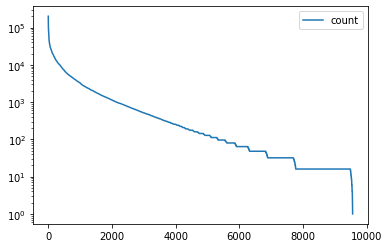

In [179]:
plot_df.plot.line(y=['count'],logy=True)

# Cluster Analysis

It's difficult to say whether the density plots are meaningful. The syllables with pauses (SC, WC, DI) seem to cluster in different areas of the embedding space, but the total numbers of those syllables are relatively lower. When looking at the raw data, the clustering is not so apparent, but the points form 'strings' in the UMAP space which does suggest they are part of some lower dimensional manifold within the embedding space (something like a hyperplane). In other words, to me there does appear to be some sort of emergent structure which should probably be further investigated.

In [201]:
%%R -i plot_df -h 5 -w 10 -u in -r 300

library('ggplot2')
library('hexbin')
library('tidyr')
library('dplyr')
library('forcats')
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

plot_df[1:4500,] %>% 
pivot_longer( cols=5:ncol(.),names_to="Feature", values_to="Value") %>%
filter(Value==TRUE) %>%
# the gross but "easy" way to do this - add a whole new column
# with observation counts per Feature
group_by(Feature) %>%
mutate(feat_count = n()) %>%
ungroup() %>%
mutate(feat_updated = paste0(Feature, " (n=", feat_count, ")")) %>%
mutate(feat_updated = fct_rev(fct_reorder(feat_updated,feat_count))) %>%


ggplot(aes(x=X, y=Y)) +
stat_density_2d(
  aes(fill = ..density..),
  geom = "raster",
  contour = FALSE,
  show.legend=FALSE
  ) +
coord_cartesian(expand=FALSE) +
scale_fill_continuous(type = "viridis", option="turbo") +

facet_wrap(~feat_updated,nrow=2) +
theme_void() +
theme(text=element_text(size=18, family="fnt",margin=margin(t=1, b=2))) +
theme(panel.spacing = unit(0.2, "lines"))

ggsave('embedding_densities_2row.pdf')

R[write to console]: Saving 10 x 5 in image



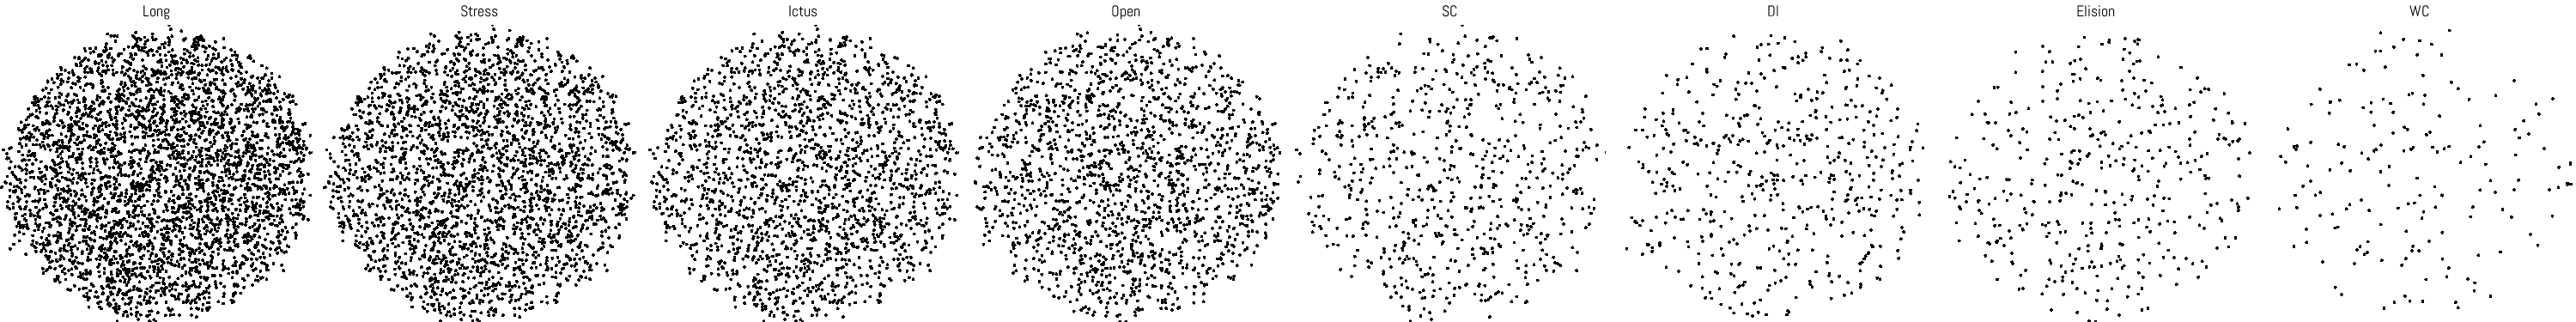

In [203]:
%%R -i plot_df -h 1.25 -w 10 -u in -r 300

library('ggplot2')
library('hexbin')
library('tidyr')
library('dplyr')
library('forcats')
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

plot_df[1:4500,] %>% 
pivot_longer( cols=5:ncol(.),names_to="Feature", values_to="Value") %>%
filter(Value==TRUE) %>%
# the gross but "easy" way to do this - add a whole new column
# with observation counts per Feature
group_by(Feature) %>%
mutate(feat_count = n()) %>%
ungroup() %>%
mutate(feat_updated = Feature) %>%
mutate(feat_updated = fct_rev(fct_reorder(feat_updated,feat_count))) %>%


ggplot(aes(x=X, y=Y)) +
geom_point(size=0.1, shape=16) +

coord_cartesian(expand=FALSE) +
scale_fill_continuous(type = "viridis", option="turbo") +

facet_wrap(~feat_updated,nrow=1) +
theme_void() +
theme(text=element_text(size=17, family="fnt",margin=margin(t=1, b=2))) +
theme(panel.spacing = unit(0.2, "lines"))

#ggsave('embedding_densities_raw_1row.pdf')

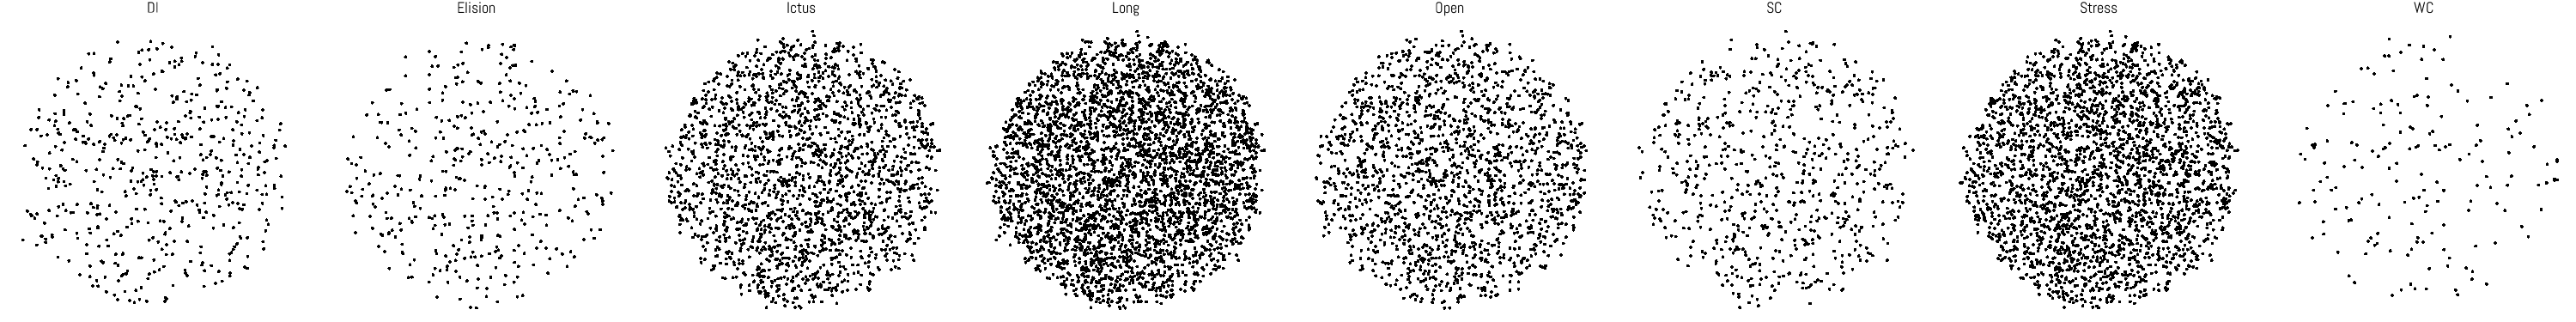

In [194]:
%%R -i plot_df -h 1.25 -w 10 -u in -r 300

library('ggplot2')
library('hexbin')
library('tidyr')
library('dplyr')
library('showtext')
font_add_google("Abel", "fnt")
showtext_auto()

df <- plot_df[1:4500,] %>% 
pivot_longer(cols=5:ncol(.),names_to="Feature", values_to="Value") %>%
filter(Value==TRUE)

ggplot(data=df,aes(x=X, y=Y)) +
geom_point(size=0.1, shape=16) +

facet_wrap(~Feature,nrow=1) +
theme_void() +
theme(text=element_text(size=17, family="fnt",margin=margin(b=1)))
# ggsave('embedding_densities_raw_1row.pdf')